<a href="https://colab.research.google.com/github/dgambone3/CSC4850-Machine-Learning/blob/main/ML_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [94]:
import pandas as pd
import sklearn 
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import ConfusionMatrixDisplay


# processing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate


# models
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import ComplementNB, MultinomialNB 
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsClassifier

In [95]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ML_Project/Diabetes Indicators Dataset/diabetes_012_health_indicators_BRFSS2015.csv')

In [96]:
X = df.iloc[:, 1:] # features
X = X.astype(int)
y = df.iloc[:, :1]
y = y.astype(int).values.ravel()

# Helper Functions


*   Learning Curves
*   Best Polynomial



### Helper function to get learning curve plot
#### Predicts target variable at every n interval of the dataset to use as points on learning curve plot.

In [98]:
def get_learning_curve(model, X, y, title):
  scores=[]
  perc=[]
  for n in range(1,101):
    perc.append(n)
    XX = X.iloc[0:int(len(X) * (n/100))] #df
    yy = y[0:int(len(y) * (n/100))] #list
    pred = model.predict(XX)
    score = MSE(y_true=yy, y_pred=pred)
    scores.append(score)
  return pd.DataFrame({'percent':perc, 'scores':scores})

### Helper function to find best polynomial for linear regression

In [99]:
def best_poly(X_train, y_train, X_test, y_test):
  degree = [1, 2]
  z = []
  poly_df = pd.DataFrame(columns=['polynomial', 'score'])
  print('   Polynomial Scores')
  for deg in degree:
    linreg = LinearRegression()
    polynomial_features = PolynomialFeatures(degree=deg,
                                             include_bias=False)
    lin_pipe = Pipeline([('scaler', MinMaxScaler()),
                        ("polynomial_features", polynomial_features),
                        ("linear_regression", linreg)])
    lin_pipe.fit(X,y)
    score = lin_pipe.score(X_test,y_test)
    z.append(score)
    print(f'Degree: {deg}  Score: {score}')
  p = z.index(max(z)) + 1
    
  return p 

### Split original data into three seperate ratios
#### Splitting data outside of loop for cohesion. This way assures the same data points are used for all the splits on all the models. 
#### Initialize dataframe labels and plot colors



In [100]:
#### SPLIT FOR FASTER TESTING -  REMOVE FOR FINAL TESTS ####
X_train_temp, X_test_temp, y_train_temp, y_test_temp = train_test_split(X, 
                                                                        y, 
                                                                        train_size=0.20)
# Create all three splits outside of loop to run each model on same data splits
X55_train, X55_test, y55_train, y55_test = train_test_split(X_train_temp, 
                                                            y_train_temp, 
                                                            train_size=.5, 
                                                            test_size=.5, 
                                                            shuffle=True,
                                                            random_state=1234)
X73_train, X73_test, y73_train, y73_test = train_test_split(X_train_temp, 
                                                            y_train_temp, 
                                                            train_size=.7, 
                                                            test_size=.3, 
                                                            shuffle=True,
                                                            random_state=1234)
X82_train, X82_test, y82_train, y82_test = train_test_split(X_train_temp, 
                                                            y_train_temp, 
                                                            train_size=.8, 
                                                            test_size=.2, 
                                                            shuffle=True,
                                                            random_state=1234)
# List of train and test motels to access later in loop
train = [(X55_train, y55_train), 
         (X73_train, y73_train), 
         (X82_train, y82_train)]
test = [(X55_test, y55_test),
        (X73_test, y73_test),
        (X82_test, y82_test)]

# initialize lists of color for plots
train_colors = ['navy', 'green', 'firebrick']
test_colors = ['skyblue', 'palegreen', 'salmon']

#### Initialize models

In [97]:
titles = ['Decision Tree Classifier',
          'Perceptron',
          'Compliment Naive Bayes',
          'Multinomial Naive Bayes',
          'Logistic Regression',
          # 'Linear Regression',
          'SVM - Linear',
          # 'SVM - RBF',
          'Gradient Boost',
          'Muti-Layer Perceptron',
          # 'Regularilized Linear Regression',
          # 'Lasso Linear Regression',
          'k-Nearest Neighbors',]
          # 'Linear Regression with Optimal Polynomial']

models = [DecisionTreeClassifier(criterion='entropy', splitter='best'),
          Perceptron(class_weight='balanced'),
          ComplementNB(),
          MultinomialNB (),
          LogisticRegression(class_weight='balanced', solver='sag'), 
          # LinearRegression(),
          LinearSVC(class_weight='balanced', dual=False),
          # SVC(kernel='rbf', decision_function_shape='ovr'),
          GradientBoostingClassifier(),
          MLPClassifier(max_iter=500, hidden_layer_sizes=10),
          # SGDRegressor(loss='squared_error', penalty='l2'),
          # Lasso(selection='random'),
          KNeighborsClassifier(weights='distance'),]
          # LinearRegression()]

# list of split ratios to output onto plots
splits = [(0.5, 0.5), 
          (0.7, 0.3),
          (0.8, 0.2)]

# create labels for fold metrics dataframe
index = []
for i in range(1,11):
  index.append(f'Fold {i}')

### Pipeline

This cell holds a nested loop which performs multiple steps to initiialize the models, get their model metrics, output learning curves, etc. Outputs for metrics of each fold, and split are generated.


1. for each model
*   scale the data
2. for each split on the model
*   fit the pipeline

*   10-fold cross-validation

*   calculate metrics for model performance on test data

*   generate and output learning curves wiht one plot for each model, and all splits on that one plot. 













,Accuracy,Precision,Recall,F1-Score,R2,Error
Fold 1,0.764289,0.779497,0.764289,0.771658,-0.694204,0.811588
Fold 2,0.765077,0.774741,0.765077,0.769847,-0.687622,0.808435
Fold 3,0.769413,0.777852,0.769413,0.773530,-0.689338,0.807647
Fold 4,0.763500,0.766624,0.763500,0.765034,-0.749555,0.838392
Fold 5,0.775325,0.784283,0.775325,0.779753,-0.596562,0.765077
Fold 6,0.772960,0.785198,0.772960,0.778863,-0.650850,0.791092
Fold 7,0.774931,0.776715,0.774931,0.775802,-0.624528,0.778479
Fold 8,0.761135,0.771623,0.761135,0.766249,-0.742152,0.834844
Fold 9,0.751577,0.766736,0.751577,0.758908,-0.821870,0.873028
Fold 10,0.767744,0.785760,0.767744,0.776383,-0.667167,0.798896


,Accuracy,Precision,Recall,F1-Score,R2,Error
Fold 1,0.771115,0.782515,0.771115,0.776696,-0.636763,0.787162
Fold 2,0.764358,0.779549,0.764358,0.771723,-0.694717,0.815034
Fold 3,0.771396,0.779622,0.771396,0.775417,-0.667789,0.802083
Fold 4,0.763232,0.774696,0.763232,0.768806,-0.726914,0.830518
Fold 5,0.770833,0.783589,0.770833,0.777084,-0.628568,0.783221
Fold 6,0.769642,0.778674,0.769642,0.774058,-0.684089,0.809913
Fold 7,0.773303,0.785580,0.773303,0.779214,-0.650126,0.793579
Fold 8,0.774430,0.792436,0.774430,0.782980,-0.621433,0.779780
Fold 9,0.761194,0.780747,0.761194,0.770554,-0.714623,0.825965
Fold 10,0.773867,0.786805,0.773867,0.780125,-0.633949,0.787102


,Accuracy,Precision,Recall,F1-Score,R2,Error
Fold 1,0.762749,0.775007,0.762749,0.768691,-0.727334,0.831486
Fold 2,0.778271,0.783523,0.778271,0.780852,-0.625997,0.782705
Fold 3,0.761518,0.775737,0.761518,0.768359,-0.743712,0.839369
Fold 4,0.776053,0.783947,0.776053,0.779946,-0.607572,0.773836
Fold 5,0.758561,0.773867,0.758561,0.765973,-0.743712,0.839369
Fold 6,0.775314,0.784144,0.775314,0.779631,-0.625997,0.782705
Fold 7,0.772604,0.780924,0.772604,0.776712,-0.617808,0.778763
Fold 8,0.780981,0.788877,0.780981,0.784849,-0.570828,0.757083
Fold 9,0.771809,0.788181,0.771809,0.779649,-0.639724,0.789305
Fold 10,0.772548,0.782119,0.772548,0.777241,-0.639724,0.789305


,Accuracy,Precision,Recall,F1-Score,R2,Error
Fold 1,0.787150,0.802291,0.787150,0.791242,-0.244117,0.595980
Fold 2,0.510840,0.843777,0.510840,0.626605,-0.366719,0.654710
Fold 3,0.792669,0.795639,0.792669,0.792534,-0.346359,0.643674
Fold 4,0.634214,0.833888,0.634214,0.693305,-1.690548,1.289318
Fold 5,0.755223,0.831543,0.755223,0.783216,-0.764361,0.845487
Fold 6,0.813953,0.802855,0.813953,0.797918,-0.135936,0.544344
Fold 7,0.151360,0.867495,0.151360,0.232894,-0.877050,0.899488
Fold 8,0.811194,0.809709,0.811194,0.783356,-0.080003,0.517540
Fold 9,0.557177,0.830394,0.557177,0.644616,-1.617601,1.254338
Fold 10,0.785095,0.796480,0.785095,0.773992,-0.186602,0.568612


,Accuracy,Precision,Recall,F1-Score,R2,Error
Fold 1,0.409628,0.871260,0.409628,0.530764,-0.339968,0.644426
Fold 2,0.807151,0.807876,0.807151,0.806994,-0.479292,0.711430
Fold 3,0.640203,0.832596,0.640203,0.690658,-1.852042,1.371622
Fold 4,0.779842,0.775939,0.779842,0.759641,-0.054881,0.507320
Fold 5,0.839245,0.783895,0.839245,0.787320,-0.157910,0.556869
Fold 6,0.714447,0.818908,0.714447,0.760421,-0.401846,0.674176
Fold 7,0.455928,0.841851,0.455928,0.572967,-0.354415,0.651366
Fold 8,0.620107,0.821035,0.620107,0.698625,-0.325722,0.637567
Fold 9,0.829062,0.797863,0.829062,0.809587,-0.254545,0.604337
Fold 10,0.540411,0.854594,0.540411,0.600400,-2.675946,1.770769


,Accuracy,Precision,Recall,F1-Score,R2,Error
Fold 1,0.466125,0.834967,0.466125,0.588316,-0.520566,0.731954
Fold 2,0.387041,0.857426,0.387041,0.471021,-2.776081,1.817689
Fold 3,0.483863,0.869075,0.483863,0.597357,-0.198130,0.576743
Fold 4,0.560237,0.836966,0.560237,0.648095,-0.154627,0.555802
Fold 5,0.726534,0.851983,0.726534,0.741981,0.000449,0.481153
Fold 6,0.827051,0.792122,0.827051,0.783586,-0.110100,0.534368
Fold 7,0.821138,0.788496,0.821138,0.775589,-0.125454,0.541759
Fold 8,0.630944,0.784702,0.630944,0.694707,-0.009563,0.486573
Fold 9,0.735091,0.832051,0.735091,0.764411,-1.078452,1.000493
Fold 10,0.734845,0.823487,0.734845,0.763295,-1.060534,0.991868


,Accuracy,Precision,Recall,F1-Score,R2,Error
Fold 1,0.723295,0.808842,0.723295,0.751805,-1.196953,1.052424
Fold 2,0.725266,0.813254,0.725266,0.753816,-1.180496,1.044541
Fold 3,0.724478,0.807978,0.724478,0.752489,-1.188967,1.046512
Fold 4,0.730784,0.821249,0.730784,0.759405,-1.131217,1.021285
Fold 5,0.730784,0.823517,0.730784,0.759434,-1.131217,1.021285
Fold 6,0.733938,0.811729,0.733938,0.759355,-1.104895,1.008672
Fold 7,0.732755,0.824832,0.732755,0.761150,-1.114766,1.013402
Fold 8,0.729602,0.815787,0.729602,0.757280,-1.141087,1.026015
Fold 9,0.715694,0.815827,0.715694,0.747131,-1.259645,1.082808
Fold 10,0.717271,0.816247,0.717271,0.748748,-1.246479,1.076498


,Accuracy,Precision,Recall,F1-Score,R2,Error
Fold 1,0.724099,0.815426,0.724099,0.753137,-1.184107,1.050394
Fold 2,0.731982,0.820201,0.731982,0.759997,-1.118543,1.018863
Fold 3,0.736205,0.813915,0.736205,0.761928,-1.083419,1.001971
Fold 4,0.719032,0.808587,0.719032,0.748589,-1.226255,1.070664
Fold 5,0.730011,0.809830,0.730011,0.756718,-1.134934,1.026745
Fold 6,0.732188,0.821305,0.732188,0.760526,-1.118579,1.018868
Fold 7,0.736131,0.819058,0.736131,0.762613,-1.085788,1.003098
Fold 8,0.727119,0.819381,0.727119,0.756309,-1.160740,1.039144
Fold 9,0.723458,0.810980,0.723458,0.751996,-1.187562,1.053788
Fold 10,0.720079,0.820799,0.720079,0.751566,-1.215623,1.067305


,Accuracy,Precision,Recall,F1-Score,R2,Error
Fold 1,0.721853,0.814037,0.721853,0.751416,-1.199216,1.058635
Fold 2,0.725055,0.814984,0.725055,0.753726,-1.172603,1.045824
Fold 3,0.728505,0.818319,0.728505,0.757115,-1.143942,1.032028
Fold 4,0.734664,0.812381,0.734664,0.760399,-1.092761,1.007391
Fold 5,0.723331,0.810705,0.723331,0.752065,-1.186933,1.052722
Fold 6,0.726780,0.810094,0.726780,0.754414,-1.158272,1.038926
Fold 7,0.728997,0.819926,0.728997,0.757716,-1.139847,1.030057
Fold 8,0.731461,0.817834,0.731461,0.758824,-1.118292,1.020941
Fold 9,0.729177,0.814251,0.729177,0.756761,-1.139884,1.030064
Fold 10,0.716609,0.817618,0.716609,0.748332,-1.244318,1.080335


,Accuracy,Precision,Recall,F1-Score,R2,Error
Fold 1,0.837603,0.787336,0.837603,0.804520,-0.242471,0.595191
Fold 2,0.841939,0.793340,0.841939,0.807223,-0.206267,0.577848
Fold 3,0.837209,0.788115,0.837209,0.805121,-0.245773,0.595585
Fold 4,0.832873,0.782972,0.832873,0.800726,-0.279059,0.612929
Fold 5,0.834450,0.778279,0.834450,0.796202,-0.265898,0.606622
Fold 6,0.835633,0.782689,0.835633,0.800058,-0.256028,0.601892
Fold 7,0.838392,0.785528,0.838392,0.802249,-0.232996,0.590855
Fold 8,0.840757,0.794117,0.840757,0.809321,-0.213255,0.581395
Fold 9,0.839905,0.791731,0.839905,0.807080,-0.222809,0.585962
Fold 10,0.837145,0.786107,0.837145,0.803213,-0.245850,0.597003


,Accuracy,Precision,Recall,F1-Score,R2,Error
Fold 1,0.841216,0.793672,0.841216,0.808660,-0.210010,0.581926
Fold 2,0.842061,0.794225,0.842061,0.808662,-0.202986,0.578547
Fold 3,0.840935,0.792513,0.840935,0.807743,-0.212352,0.583052
Fold 4,0.837838,0.789872,0.837838,0.805820,-0.238109,0.595439
Fold 5,0.838401,0.788199,0.838401,0.804155,-0.233426,0.593187
Fold 6,0.835258,0.786060,0.835258,0.802682,-0.261310,0.606590
Fold 7,0.833568,0.779347,0.833568,0.797606,-0.275364,0.613348
Fold 8,0.836666,0.784149,0.836666,0.801428,-0.249599,0.600957
Fold 9,0.838355,0.792180,0.838355,0.807648,-0.233500,0.594199
Fold 10,0.838355,0.790080,0.838355,0.806204,-0.233500,0.594199


,Accuracy,Precision,Recall,F1-Score,R2,Error
Fold 1,0.834196,0.780808,0.834196,0.798789,-0.265688,0.609263
Fold 2,0.839862,0.790904,0.839862,0.806352,-0.218602,0.586598
Fold 3,0.842079,0.794227,0.842079,0.808545,-0.200177,0.577729
Fold 4,0.841587,0.792696,0.841587,0.807324,-0.204272,0.579699
Fold 5,0.837398,0.787038,0.837398,0.803339,-0.239074,0.596452
Fold 6,0.834196,0.785019,0.834196,0.802221,-0.265688,0.609263
Fold 7,0.833457,0.779008,0.833457,0.797024,-0.271830,0.612220
Fold 8,0.837645,0.786655,0.837645,0.802808,-0.237034,0.596206
Fold 9,0.838590,0.791165,0.838590,0.806871,-0.230689,0.592410
Fold 10,0.837358,0.788330,0.837358,0.804767,-0.240928,0.597339


,Accuracy,Precision,Recall,F1-Score,R2,Error
Fold 1,0.443831,0.868498,0.443831,0.567453,-0.911431,0.915648
Fold 2,0.396531,0.858029,0.396531,0.509955,-1.390318,1.145053
Fold 3,0.593615,0.811199,0.593615,0.681320,-0.448593,0.692550
Fold 4,0.734332,0.825736,0.734332,0.767113,-0.921467,0.920773
Fold 5,0.230981,0.847473,0.230981,0.295535,-3.454909,2.134805
Fold 6,0.232952,0.844426,0.232952,0.347404,-0.953547,0.936145
Fold 7,0.301143,0.824849,0.301143,0.341309,-4.132687,2.459598
Fold 8,0.397320,0.885284,0.397320,0.529498,-0.373652,0.658258
Fold 9,0.517744,0.851206,0.517744,0.625658,-0.942011,0.930599
Fold 10,0.726341,0.812680,0.726341,0.761239,-0.859723,0.891167


,Accuracy,Precision,Recall,F1-Score,R2,Error
Fold 1,0.424550,0.846451,0.424550,0.553423,-0.609249,0.773930
Fold 2,0.484516,0.832383,0.484516,0.600042,-0.965755,0.945383
Fold 3,0.671453,0.837368,0.671453,0.721863,-1.379629,1.144426
Fold 4,0.386261,0.796291,0.386261,0.441621,-3.930778,2.371340
Fold 5,0.488176,0.838310,0.488176,0.594032,-1.388410,1.148649
Fold 6,0.632498,0.827804,0.632498,0.712971,-0.489681,0.716418
Fold 7,0.660096,0.799982,0.660096,0.718504,-0.390135,0.668544
Fold 8,0.423543,0.843689,0.423543,0.548632,-0.934711,0.930442
Fold 9,0.302168,0.850193,0.302168,0.430389,-0.690655,0.814418
Fold 10,0.522388,0.834724,0.522388,0.595089,-2.516936,1.694171


,Accuracy,Precision,Recall,F1-Score,R2,Error
Fold 1,0.025376,0.892324,0.025376,0.014628,-1.113745,1.017492
Fold 2,0.696231,0.806990,0.696231,0.737385,-1.158784,1.039172
Fold 3,0.638827,0.832557,0.638827,0.714053,-0.174075,0.565164
Fold 4,0.703868,0.832660,0.703868,0.760003,-0.390568,0.669377
Fold 5,0.830007,0.774478,0.830007,0.794217,-0.294349,0.623060
Fold 6,0.358463,0.849614,0.358463,0.412162,-3.725986,2.274945
Fold 7,0.339985,0.875609,0.339985,0.461937,-1.023668,0.974132
Fold 8,0.608032,0.806722,0.608032,0.678532,-1.389724,1.151762
Fold 9,0.527600,0.851569,0.527600,0.586047,-2.810324,1.834155
Fold 10,0.740020,0.824888,0.740020,0.772380,-0.797912,0.865451


,Accuracy,Precision,Recall,F1-Score,R2,Error
Fold 1,0.826173,0.824795,0.826173,0.824139,-0.328046,0.636184
Fold 2,0.825778,0.818298,0.825778,0.821312,-0.326400,0.635396
Fold 3,0.812771,0.812965,0.812771,0.812356,-0.430455,0.683879
Fold 4,0.815530,0.812053,0.815530,0.813473,-0.409021,0.675207
Fold 5,0.819866,0.823443,0.819866,0.820868,-0.355556,0.649586
Fold 6,0.818683,0.819933,0.818683,0.818317,-0.377765,0.660229
Fold 7,0.819078,0.812222,0.819078,0.815486,-0.379410,0.661017
Fold 8,0.825778,0.821066,0.825778,0.823229,-0.308671,0.627119
Fold 9,0.815852,0.818046,0.815852,0.816328,-0.393969,0.667981
Fold 10,0.816246,0.817908,0.816246,0.816386,-0.405489,0.673502


,Accuracy,Precision,Recall,F1-Score,R2,Error
Fold 1,0.815597,0.817440,0.815597,0.815815,-0.396751,0.671734
Fold 2,0.812218,0.813363,0.812218,0.811591,-0.440656,0.692849
Fold 3,0.827984,0.817854,0.827984,0.822845,-0.309528,0.629786
Fold 4,0.827140,0.822575,0.827140,0.824559,-0.313040,0.631475
Fold 5,0.819257,0.813736,0.819257,0.816313,-0.376848,0.662162
Fold 6,0.816671,0.813479,0.816671,0.814789,-0.401846,0.674176
Fold 7,0.822867,0.825710,0.822867,0.823455,-0.338019,0.643481
Fold 8,0.815827,0.811055,0.815827,0.813266,-0.403603,0.675021
Fold 9,0.818924,0.813445,0.818924,0.816045,-0.372049,0.660941
Fold 10,0.819206,0.822183,0.819206,0.819897,-0.374972,0.662349


,Accuracy,Precision,Recall,F1-Score,R2,Error
Fold 1,0.814979,0.813174,0.814979,0.813345,-0.410017,0.678739
Fold 2,0.823109,0.820204,0.823109,0.820787,-0.345529,0.647696
Fold 3,0.811530,0.815164,0.811530,0.811768,-0.443284,0.694752
Fold 4,0.830500,0.818924,0.830500,0.824627,-0.294861,0.623306
Fold 5,0.828776,0.819566,0.828776,0.824055,-0.301514,0.626509
Fold 6,0.815472,0.812291,0.815472,0.813510,-0.413599,0.680463
Fold 7,0.819167,0.818701,0.819167,0.818347,-0.379820,0.664203
Fold 8,0.819167,0.815101,0.819167,0.816615,-0.371983,0.661247
Fold 9,0.822080,0.815382,0.822080,0.818555,-0.357137,0.653277
Fold 10,0.818876,0.822062,0.818876,0.819625,-0.376078,0.662395


,Accuracy,Precision,Recall,F1-Score,R2,Error
Fold 1,0.857312,0.817715,0.857312,0.817299,-0.077906,0.516358
Fold 2,0.851793,0.807912,0.851793,0.812592,-0.123984,0.538431
Fold 3,0.858494,0.819463,0.858494,0.822868,-0.067688,0.510445
Fold 4,0.848246,0.800368,0.848246,0.809164,-0.150742,0.551439
Fold 5,0.850217,0.805804,0.850217,0.812974,-0.131823,0.542373
Fold 6,0.846275,0.796044,0.846275,0.806384,-0.164725,0.558140
Fold 7,0.851005,0.806410,0.851005,0.813058,-0.127711,0.540402
Fold 8,0.846275,0.797685,0.846275,0.807597,-0.167193,0.559322
Fold 9,0.853707,0.813617,0.853707,0.819649,-0.102667,0.528391
Fold 10,0.848580,0.801769,0.848580,0.812252,-0.150395,0.551262


,Accuracy,Precision,Recall,F1-Score,R2,Error
Fold 1,0.852477,0.808385,0.852477,0.814097,-0.116347,0.536881
Fold 2,0.851351,0.807999,0.851351,0.815630,-0.125714,0.541385
Fold 3,0.847691,0.799681,0.847691,0.807801,-0.156154,0.556025
Fold 4,0.854730,0.813117,0.854730,0.814456,-0.097615,0.527872
Fold 5,0.854448,0.812399,0.854448,0.816940,-0.099956,0.528998
Fold 6,0.851873,0.808084,0.851873,0.814578,-0.123116,0.540130
Fold 7,0.848493,0.800591,0.848493,0.807999,-0.151224,0.553647
Fold 8,0.847367,0.798964,0.847367,0.807456,-0.160593,0.558153
Fold 9,0.847649,0.801578,0.847649,0.810279,-0.156333,0.557026
Fold 10,0.852718,0.810903,0.852718,0.818556,-0.114242,0.536750


,Accuracy,Precision,Recall,F1-Score,R2,Error
Fold 1,0.847746,0.800447,0.847746,0.809446,-0.153092,0.555063
Fold 2,0.853659,0.810473,0.853659,0.815691,-0.103958,0.531412
Fold 3,0.851441,0.808802,0.851441,0.817167,-0.122383,0.540281
Fold 4,0.849963,0.804405,0.849963,0.809587,-0.134667,0.546194
Fold 5,0.852427,0.808853,0.852427,0.813742,-0.112659,0.535600
Fold 6,0.854890,0.814104,0.854890,0.818569,-0.093722,0.526484
Fold 7,0.848978,0.803247,0.848978,0.811822,-0.142856,0.550136
Fold 8,0.850702,0.805921,0.850702,0.812622,-0.128665,0.543976
Fold 9,0.847462,0.801078,0.847462,0.810543,-0.156971,0.556925
Fold 10,0.856826,0.818280,0.856826,0.824683,-0.079157,0.519468


,Accuracy,Precision,Recall,F1-Score,R2,Error
Fold 1,0.852976,0.809131,0.852976,0.811053,-0.114110,0.533701
Fold 2,0.852582,0.809916,0.852582,0.816813,-0.117401,0.535278
Fold 3,0.847458,0.796478,0.847458,0.803545,-0.160029,0.554592
Fold 4,0.847852,0.800557,0.847852,0.811482,-0.154032,0.553015
Fold 5,0.848246,0.801473,0.848246,0.807950,-0.150742,0.551439
Fold 6,0.848640,0.801588,0.848640,0.808835,-0.147452,0.549862
Fold 7,0.852976,0.809970,0.852976,0.810233,-0.111260,0.532519
Fold 8,0.845881,0.797076,0.845881,0.808819,-0.170483,0.560899
Fold 9,0.854101,0.813596,0.854101,0.819230,-0.104313,0.529180
Fold 10,0.846609,0.793574,0.846609,0.802235,-0.166852,0.559148


,Accuracy,Precision,Recall,F1-Score,R2,Error
Fold 1,0.853604,0.809944,0.853604,0.813182,-0.106981,0.532376
Fold 2,0.851351,0.807390,0.851351,0.813040,-0.125714,0.541385
Fold 3,0.849662,0.803759,0.849662,0.811681,-0.139763,0.548142
Fold 4,0.851070,0.805871,0.851070,0.811501,-0.128055,0.542511
Fold 5,0.848536,0.801375,0.848536,0.808016,-0.149129,0.552646
Fold 6,0.853844,0.811972,0.853844,0.815643,-0.106721,0.532244
Fold 7,0.848493,0.799775,0.848493,0.804008,-0.151224,0.553647
Fold 8,0.850746,0.805729,0.850746,0.811023,-0.132485,0.544635
Fold 9,0.846522,0.798484,0.846522,0.806099,-0.165686,0.561532
Fold 10,0.847930,0.802232,0.847930,0.814152,-0.153994,0.555900


,Accuracy,Precision,Recall,F1-Score,R2,Error
Fold 1,0.850456,0.805228,0.850456,0.809129,-0.130572,0.544223
Fold 2,0.850456,0.803064,0.850456,0.809000,-0.130572,0.544223
Fold 3,0.851934,0.809575,0.851934,0.817527,-0.118289,0.538310
Fold 4,0.850949,0.807296,0.850949,0.813859,-0.126478,0.542252
Fold 5,0.856369,0.816668,0.856369,0.820179,-0.081439,0.520572
Fold 6,0.855876,0.821180,0.855876,0.810548,-0.085534,0.522542
Fold 7,0.846268,0.796475,0.846268,0.805805,-0.165375,0.560976
Fold 8,0.849224,0.804423,0.849224,0.814061,-0.140934,0.549889
Fold 9,0.847462,0.798708,0.847462,0.805850,-0.156971,0.556925
Fold 10,0.852144,0.809786,0.852144,0.817373,-0.118064,0.538196


,Accuracy,Precision,Recall,F1-Score,R2,Error
Fold 1,0.818289,0.772599,0.818289,0.791564,-0.391403,0.666535
Fold 2,0.819866,0.772772,0.819866,0.790259,-0.380707,0.661411
Fold 3,0.818683,0.772816,0.818683,0.792074,-0.390880,0.664959
Fold 4,0.821837,0.777556,0.821837,0.795834,-0.363781,0.653528
Fold 5,0.823808,0.777131,0.823808,0.795514,-0.334992,0.639732
Fold 6,0.821048,0.779104,0.821048,0.796324,-0.355556,0.649586
Fold 7,0.826961,0.782087,0.826961,0.797081,-0.321009,0.633031
Fold 8,0.813165,0.766341,0.813165,0.786137,-0.428762,0.684667
Fold 9,0.824527,0.783806,0.824527,0.798260,-0.341304,0.642744
Fold 10,0.819401,0.778597,0.819401,0.794474,-0.384094,0.663249


,Accuracy,Precision,Recall,F1-Score,R2,Error
Fold 1,0.816723,0.770129,0.816723,0.789332,-0.397922,0.672297
Fold 2,0.817849,0.775196,0.817849,0.793188,-0.395581,0.671171
Fold 3,0.821791,0.771342,0.821791,0.791391,-0.359286,0.653716
Fold 4,0.820664,0.777113,0.820664,0.795005,-0.366896,0.657376
Fold 5,0.818694,0.774263,0.818694,0.792647,-0.381531,0.664414
Fold 6,0.822867,0.777582,0.822867,0.795909,-0.352073,0.650239
Fold 7,0.824838,0.784299,0.824838,0.800650,-0.328650,0.638975
Fold 8,0.820332,0.775480,0.820332,0.792907,-0.369640,0.658688
Fold 9,0.816671,0.775089,0.816671,0.791165,-0.406540,0.677556
Fold 10,0.823712,0.780061,0.823712,0.797914,-0.346327,0.648550


,Accuracy,Precision,Recall,F1-Score,R2,Error
Fold 1,0.822370,0.774627,0.822370,0.792622,-0.347065,0.648436
Fold 2,0.814979,0.767463,0.814979,0.787117,-0.405410,0.676521
Fold 3,0.816457,0.775026,0.816457,0.792683,-0.402339,0.675043
Fold 4,0.820645,0.770561,0.820645,0.790521,-0.369072,0.659029
Fold 5,0.819906,0.773894,0.819906,0.792872,-0.376749,0.662725
Fold 6,0.824834,0.781524,0.824834,0.799064,-0.335805,0.643016
Fold 7,0.823109,0.777893,0.823109,0.795893,-0.342459,0.646218
Fold 8,0.828036,0.784979,0.828036,0.800451,-0.307575,0.630204
Fold 9,0.820848,0.775393,0.820848,0.793518,-0.359697,0.654510
Fold 10,0.827008,0.786928,0.827008,0.802240,-0.316182,0.633563


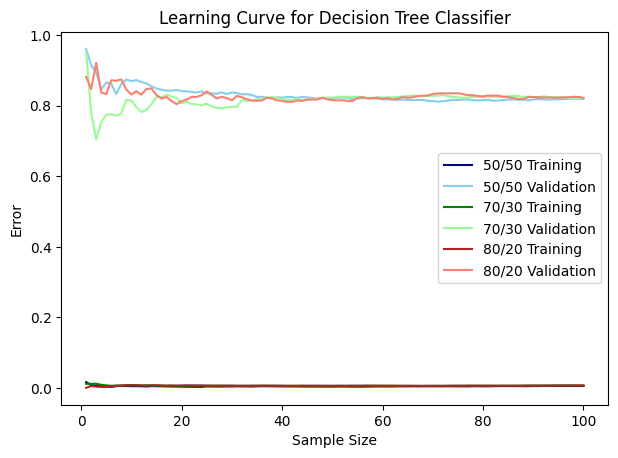

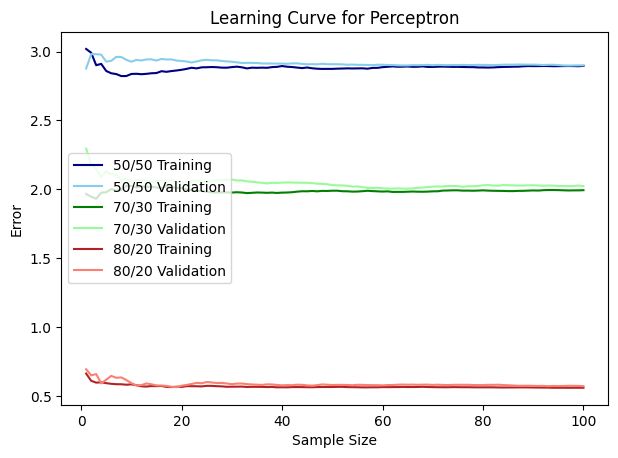

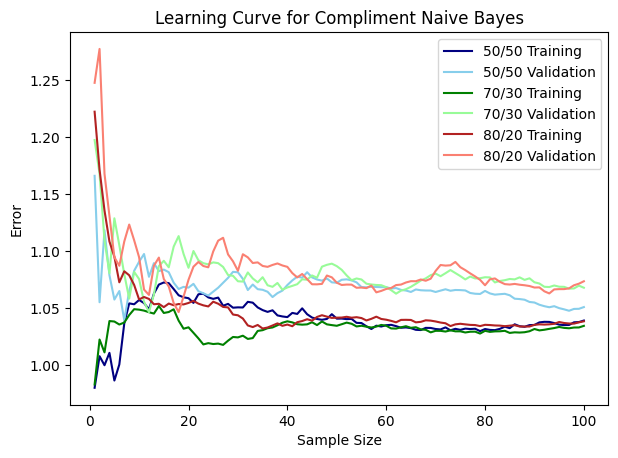

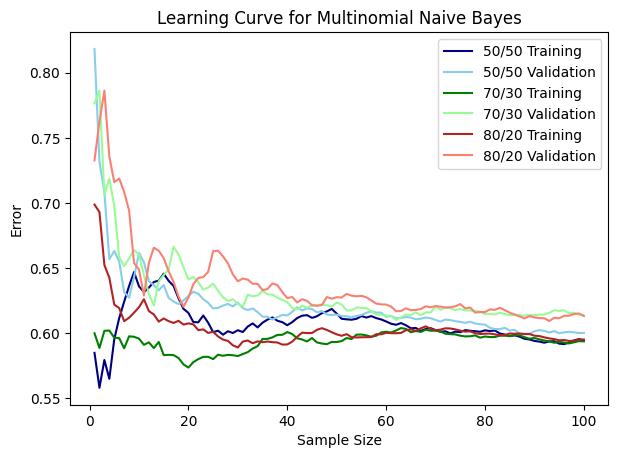

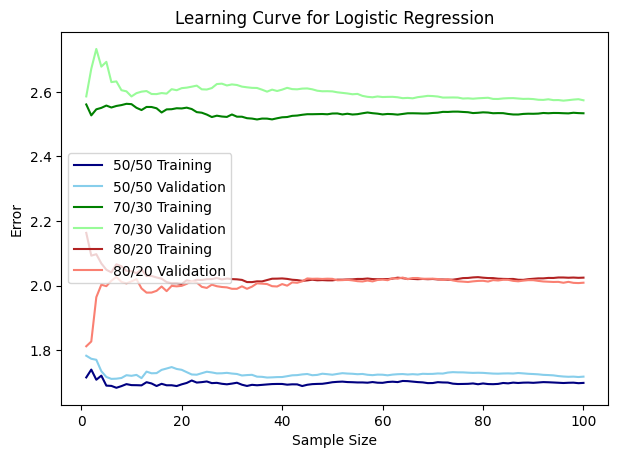

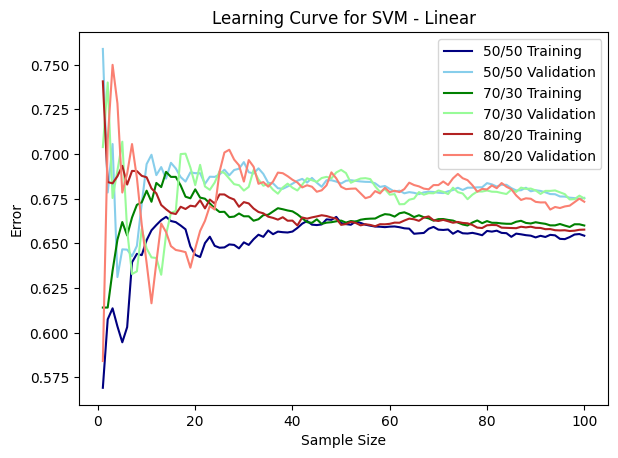

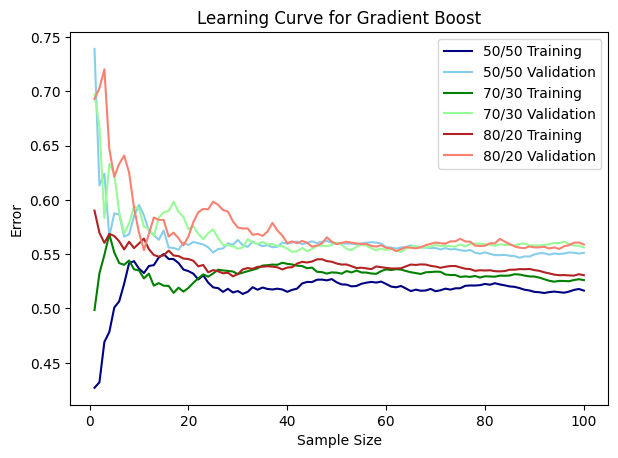

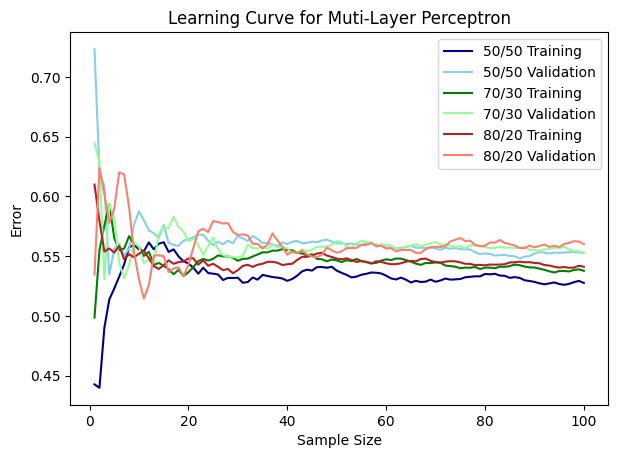

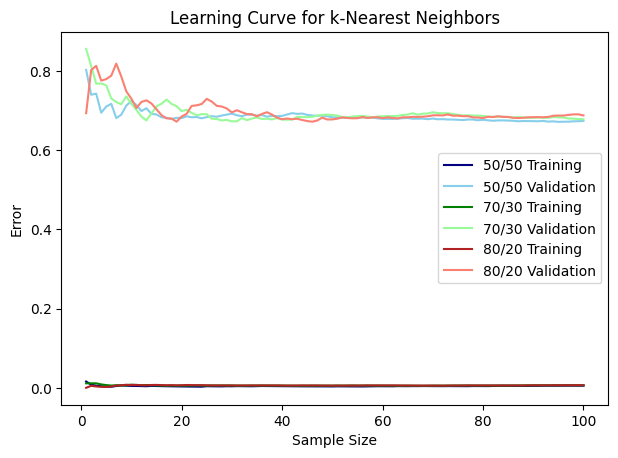

In [101]:
i = 0
# dataframe to store all split information, will be used to pick the best splits
splits_df = pd.DataFrame(columns=['Model', 
                                  'Split', 
                                  'Error',  
                                  'Generalization', 
                                  'true', 
                                  'pred'])
# dataframe to hold all model and split metrics
big_df = pd.DataFrame(columns=['Model', 'Split'])

for model in models: # for each model in model list
    # print(titles[i])
    pipe = make_pipeline(MinMaxScaler(), model) # make pipeline with steps to use MinMaxScaler to [0,1]
    # for plotting learning curves
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    # dataframe to hold and output all metridcs for every split on model
    fold_df = pd.DataFrame(columns=['Accuracy',
                                    'Precision', 
                                    'Recall', 
                                    'F1-Score', 
                                    'R2'
                                    'Error'],
                                    index=index)
    j=0
    for j in range(len(splits)): # for each data split
      # rename variables for test/train data, based on list of tuples in previous cell
      X_train = train[j][0]
      y_train = train[j][1]
      X_test = test[j][0]
      y_test = test[j][1]

      # condition to call polynomial function only on this model type
      if 'Polynomial' in titles[i]:
        poly_df = pd.DataFrame(columns=['polynomial', 'score'])
        poly = best_poly(X_train, y_train, X_test, y_test)       
        pipe = make_pipeline(MinMaxScaler(),
                             PolynomialFeatures(degree=poly),
                             LinearRegression())
      # fit data to the training dataset
      pipe.fit(X_train, y_train)
      
      # print(splits[j])
      # conduct 10-fold cross validation with specific scores
      cv = cross_validate(pipe, 
                          X_train, 
                          y_train,
                          scoring=['accuracy', 
                                    'precision_weighted',
                                    'recall_weighted',
                                    'f1_weighted',
                                    'r2',
                                    'neg_mean_squared_error'], 
                          cv=10) 
      # variable to hold predicted values on test set
      pred = pipe.predict(X_test)
      # calculate test error on test set
      test_error = MSE(y_test, pred)

      # adding absolute value of neg mean squared error so lower error is better, 
      # while CV uses neg_MSE to follow convention of all other metrics that higher is better
      # concat metrics to dataframe
      fold_df = pd.concat({'Accuracy':pd.Series(cv['test_accuracy']), 
                            'Precision':pd.Series(cv['test_precision_weighted']),
                            'Recall':pd.Series(cv['test_recall_weighted']),
                            'F1-Score':pd.Series(cv['test_f1_weighted']),
                            'R2' : pd.Series(cv['test_r2']),
                            'Error':pd.Series(abs(cv['test_neg_mean_squared_error']))},
                            axis=1)
      # add metrics to best splits dataframe, generalization is calculated from the difference between test and train errors
      splits_df.loc[len(splits_df)] = [titles[i], 
                                      splits[j], 
                                      fold_df['Error'].min(),
                                      abs(fold_df['Error'].min() - test_error),
                                      test[j][1],
                                      pred]
      # concat data to big dataframe for final output
      big_df = pd.concat([big_df, fold_df], ignore_index=True, axis=0)
      # add split identification to rows all 10 rows of the cross validation fold
      big_df['Split'].iloc[((i*30)+(j*10)):((i*30)+(j*10)+10)] = str(splits[j])
      
      fold_df.index = index # set index for visualation purposes
      # create display caption for fold dataframe, for visualization purposes
      fold_disp = fold_df.style.set_caption(f'Fold Metrics for {titles[i]} with {int(splits[j][0] * 100)}/{int(splits[j][1]*100)} Split')
      # print('\n')
      display(fold_disp) # display fold metrics
      
      # PLOT LEARNING CURVES
      # get training and testing scores by calling learning curve function
      train_scores = get_learning_curve(pipe, X_train, y_train, titles[i])
      test_scores = get_learning_curve(pipe, X_test, y_test, titles[i])
      # plot training scores
      ax.plot(train_scores['percent'], 
              train_scores['scores'], 
              color=train_colors[j],
              label=f'{int(splits[j][0] * 100)}/{int(splits[j][1]*100)} Training')
      # plot testing scores
      ax.plot(test_scores['percent'], 
              test_scores['scores'],  
              color=test_colors[j],
              label=f'{int(splits[j][0] * 100)}/{int(splits[j][1]*100)} Validation')
      # set labeles and titles
      ax.set_xlabel('Sample Size')
      ax.set_ylabel('Error')
      ax.set_title(f'Learning Curve for {titles[i]}')
      ax.legend(loc='best')
      fig.tight_layout(pad=1.5)
      fig.show()
      j += 1 # increment to next split
    # add model name to all 30 fold metrics (10 + 10 + 10 -> 10 folds, 3 splits, 1 model)
    big_df['Model'].iloc[(i*30):((i*30)+30)] = titles[i]
    i+=1  # increment to next fold
    


At this point, split_df holds the metrics for the best fold for each split, so there are three rows for every model, one for each split (50/50, 70/30, 80/20) for a total of (15models * 3splits).

The following cell selects the *best split* based on all the best folds for each model, which was selected in the previous cell. The dataframe groups by model name, and selects the split for each model based on which of the three has the lowest error. 

In [102]:
best = (splits_df.loc[splits_df.groupby('Model', sort=False)['Error'].idxmin()])
display(best)

,Model,Split,Error,Generalization,true,pred
2,Decision Tree Classifier,"(0.8, 0.2)",0.757083,0.064655,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, ...","[2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, ..."
5,Perceptron,"(0.8, 0.2)",0.481153,0.088812,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, ...","[0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, ..."
7,Compliment Naive Bayes,"(0.7, 0.3)",1.001971,0.065962,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, ...","[2, 2, 0, 0, 0, 0, 2, 2, 2, 0, 2, 0, 2, 2, 0, ..."
11,Multinomial Naive Bayes,"(0.8, 0.2)",0.577729,0.035496,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, ...","[2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, ..."
14,Logistic Regression,"(0.8, 0.2)",0.565164,1.443508,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, ...","[2, 1, 1, 2, 2, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, ..."
17,SVM - Linear,"(0.8, 0.2)",0.623306,0.050028,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, ...","[0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 2, 0, ..."
18,Gradient Boost,"(0.5, 0.5)",0.510445,0.040800,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
23,Muti-Layer Perceptron,"(0.8, 0.2)",0.520572,0.039440,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
26,k-Nearest Neighbors,"(0.8, 0.2)",0.630204,0.057222,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, ...","[2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, ..."


#### Generating Confusion Matrix
This cell generates and outputs the Confusion Matricies for all applicable models. If 'Linear Regression' is in the model name, the function is skipped as confusion matricies are not applicable for continuious values. 

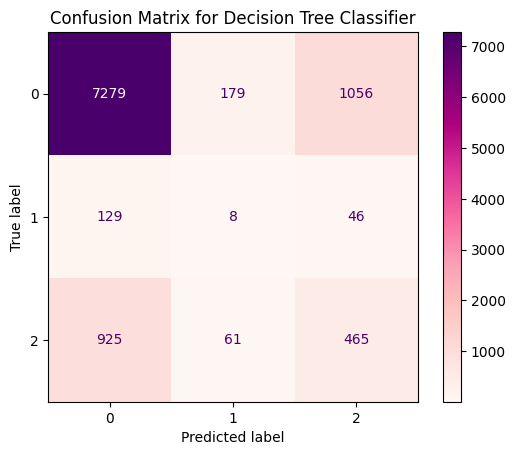

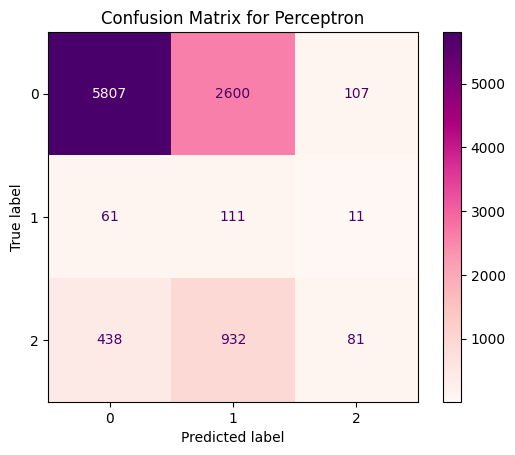

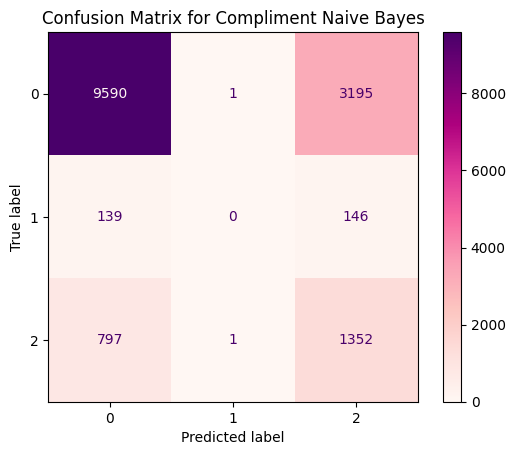

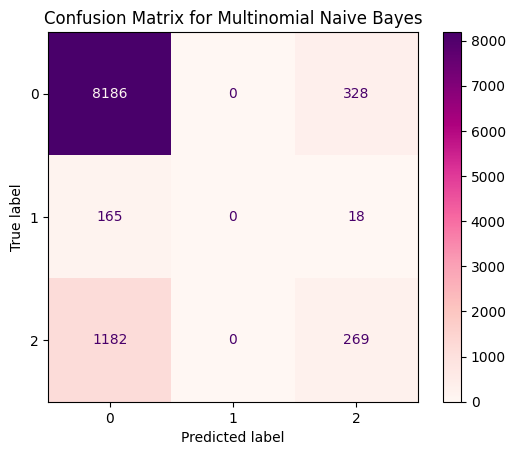

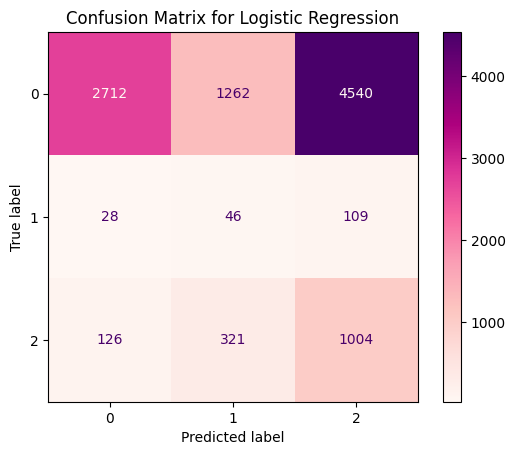

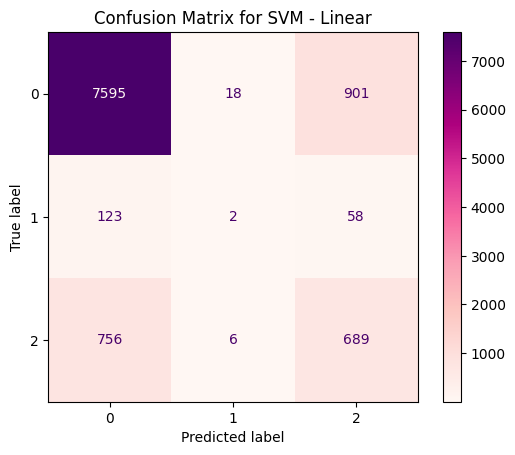

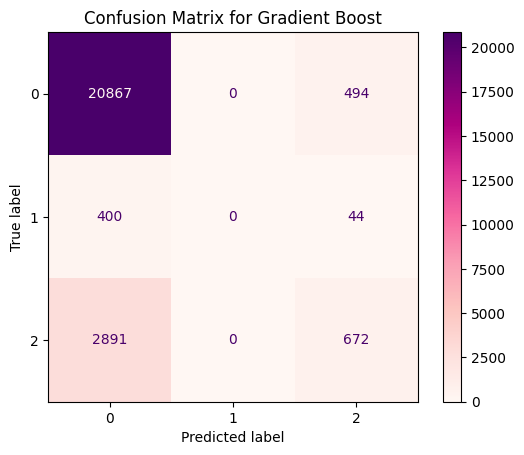

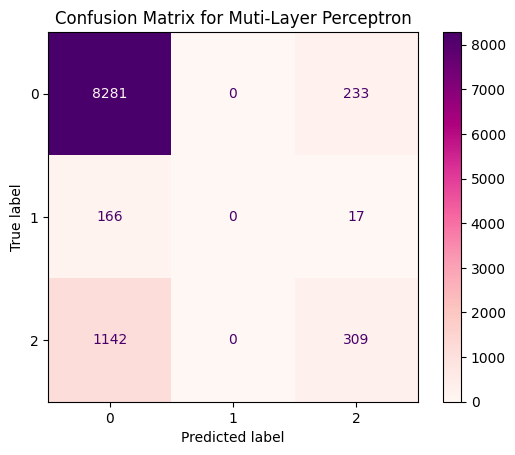

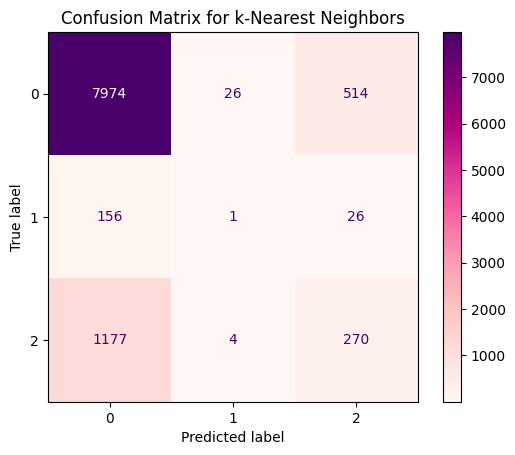

In [103]:
# loop to generate confusion matrix
for b in range(len(best)):
  # skip models with Linear Regression in the title because cannot calculate confision matrix for continuious values
  if 'Linear Regression' not in best.iloc[b]['Model']:
    ConfusionMatrixDisplay.from_predictions(y_true=best.iloc[b]['true'], 
                                            y_pred=best.iloc[b]['pred'],
                                            cmap='RdPu')
    # set titles
    title=best.iloc[b]['Model']
    plt.title(f'Confusion Matrix for {title}')
    plt.show()
  else:
    # output confirmation that regression model was skipped
    print('Cannot calculate Confusion Matrix for Regression Problems - ', titles[b])

Selecting columns to display for the dataframe with all the best models. This dataframe holds one row for each model, indicating the best split, for each model, based on the best fold for that split, with the lowest MSE.

In [104]:
# drop columns with y_true and y_pred that were used to generate matrix
best = best.drop(['true', 'pred'], axis=1)

# adjust dataframe for better display
best.reset_index(inplace=True, drop=True) 
disp_best = best.style.set_caption(f'Best Split for Each Model')
display(disp_best)

,Model,Split,Error,Generalization
0,Decision Tree Classifier,"(0.8, 0.2)",0.757083,0.064655
1,Perceptron,"(0.8, 0.2)",0.481153,0.088812
2,Compliment Naive Bayes,"(0.7, 0.3)",1.001971,0.065962
3,Multinomial Naive Bayes,"(0.8, 0.2)",0.577729,0.035496
4,Logistic Regression,"(0.8, 0.2)",0.565164,1.443508
5,SVM - Linear,"(0.8, 0.2)",0.623306,0.050028
6,Gradient Boost,"(0.5, 0.5)",0.510445,0.040800
7,Muti-Layer Perceptron,"(0.8, 0.2)",0.520572,0.039440
8,k-Nearest Neighbors,"(0.8, 0.2)",0.630204,0.057222


Display big_df with every metric for every model, for ever split. 

In [105]:
#output big_df with all metrics for every model, on every split
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(big_df)

,Model,Split,Accuracy,Precision,Recall,F1-Score,R2,Error
0,Decision Tree Classifier,"(0.5, 0.5)",0.764289,0.779497,0.764289,0.771658,-0.694204,0.811588
1,Decision Tree Classifier,"(0.5, 0.5)",0.765077,0.774741,0.765077,0.769847,-0.687622,0.808435
2,Decision Tree Classifier,"(0.5, 0.5)",0.769413,0.777852,0.769413,0.773530,-0.689338,0.807647
3,Decision Tree Classifier,"(0.5, 0.5)",0.763500,0.766624,0.763500,0.765034,-0.749555,0.838392
4,Decision Tree Classifier,"(0.5, 0.5)",0.775325,0.784283,0.775325,0.779753,-0.596562,0.765077
5,Decision Tree Classifier,"(0.5, 0.5)",0.772960,0.785198,0.772960,0.778863,-0.650850,0.791092
6,Decision Tree Classifier,"(0.5, 0.5)",0.774931,0.776715,0.774931,0.775802,-0.624528,0.778479
7,Decision Tree Classifier,"(0.5, 0.5)",0.761135,0.771623,0.761135,0.766249,-0.742152,0.834844
8,Decision Tree Classifier,"(0.5, 0.5)",0.751577,0.766736,0.751577,0.758908,-0.821870,0.873028
9,Decision Tree Classifier,"(0.5, 0.5)",0.767744,0.785760,0.767744,0.776383,-0.667167,0.798896
